In [1]:
# This code was written by Yara Al-Shorman
# Last updated: June 12 2022

## Important Notes!

This code was initially intended to rotate our data to make 'more' data.

We concluded that rotating existing data does not make the model train any better. It just somehow finds a 'trick' to get good at predictions.

But compeletely flops when faced with new data.

So we decided to not rotate our data anymore and use distinct catalogues 100%.

I am going to continue using this code so I dont have to completely overhaul my existing code.

I also think it's a good idea to process our data before using it (and add error, account for zone of avoidance, give the data better structure...etc.)


Hence why I will keep using this code. But to be clear:

#### It does not rotate the data! It just makes it easier to deal with, and makes it more realistic

### Imports

In [2]:
# imports
import numpy as np
from astropy import units as u
from astropy import coordinates as c
from astropy.cosmology import units as cu
import matplotlib.pyplot as plt
from matplotlib import rcParams as P
from scipy.spatial.transform import Rotation as R
import math
import os

### Helper functions

#### angle generator

In [3]:
def generate_angles():
    # generates the 3 needed euler angles at random
    # angles
    alpha = 2 * np.pi * np.random.random()  #generate random rotation angles
    beta = np.pi * np.random.random()
    gamma = 2 * np.pi * np.random.random()
    
    # alpha, beta, gamma = 0.1, 0, 0
    
    return (alpha, beta, gamma)

#### galaxy rotator

In [4]:
# This function performs an Euler rotation on the data, returns the new glon and glat
# prof. watkins' code (plus some additions of my own)
# uses scipy to preform a random euler rotation  
def rotate(array, angles):
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # data part
    glon = array[10] * np.pi / 180
    glat = array[11] * np.pi / 180

    #make glon and glat into array of positions on the unit sphere
    pos = np.array([np.cos(glon) * np.sin(glat),  # alpha
                    np.sin(glon) * np.sin(glat),  # beta
                    np.cos(glat)])                # gamma

    pos = np.transpose(pos)

    r = R.from_euler('xzx', [alpha, beta, gamma]) #create the rotation
    posprime = r.apply(pos)  #apply the rotation to the vectors

    glonprime = np.arctan2(posprime[1], posprime[0]) * 180 / np.pi  #convert back to degrees
    # glonprime[glonprime < 0] = 360 + glonprime[glonprime < 0]
    if glonprime < 0:
        glonprime += 360

    glatprime = np.arcsin(posprime[2]) * 180/np.pi
    
    # glonprime, glatprime = c.Angle(glonprime, u.degree), c.Angle(glatprime, u.degree)
    glonprime = c.Angle(glonprime, u.degree)
    glatprime = c.Angle(glatprime, u.degree)
    
    # print(f'{alpha=}, {beta=}, {gamma=}')  # angles of rotation (radians)
    glonprime, glatprime = glonprime.wrap_at('180d', inplace=False).value, glatprime.value
    
    return glonprime, glatprime

#### bulkflow generator

In [5]:
def generate_bulkflow(vx_array, vy_array, vz_array, distance, radius):
    within_radius = np.where(distance <= radius)  # filter based on desired radius
    
    # fitler velocities based on radius, for each catalogue
    vx_array = vx_array[within_radius]
    vy_array = vy_array[within_radius]
    vz_array = vz_array[within_radius]
    
    # evaluate bulkflows, simply the average of the velocities in every direction
    bx = sum(vx_array)/len(vx_array)
    by = sum(vy_array)/len(vy_array)
    bz = sum(vz_array)/len(vz_array)
    
    # return bulkflow array
    return np.array([bx, by, bz])

#### bulkflow rotator

In [6]:
def rotate_bulkflow(bulkflow, angles: tuple):
    # rotates one bulkflow for ONE catalogue at a time, to be used in a loop in sync with the previous rotate function
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # rotation part
    r = R.from_euler('xzx', [alpha, beta, gamma])
    bulkflowprime = r.apply(bulkflow)
        
    return bulkflowprime  # returns an array of the new components of the new bulkflow

#### distance modulus 

In [7]:
# evaluating distance mod
# this also adds error to the distance modulus
def distance_mod(line, error):
    distance = line[7]
    return 5 * math.log10(distance) + 25 + error

#### Loading, processing, rotating the data

In [12]:
# you must change file paths to work for your device.
def main():
    # load the data
    i = 0
    path = 'C:/Users/yaras/OneDrive/Desktop/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-LG'
    for file in os.listdir(path):
        data = np.load(path + "/" + file)
        # generating multiple versions of each catalogue

        new_cat = np.empty((0,4))
        
        '''
        generating angles of rotation
        'angles' will be a tuple with 3 elements (alpha, beta, gamma)
        look cell No. 4 (generate angles) for function definition
        '''
        # angles = generate_angles()

        '''
        rotating the bulkflows
        'bulkflow' will be a 1x3 array with the xyz components
        of the bulkflow for the respective catalogue
        look cell No. 6 (bulkflow rotator) for function definition
        '''
        # bulkflow = bulkflows[:,i]
        # bulkflow_prime = rotate_bulkflow(bulkflow, angles)
        # header = np.array([bulkflow_prime[0], bulkflow_prime[1], bulkflow_prime[2]])
        # header = np.array([bulkflow[0], bulkflow[1], bulkflow[2]])
        
        
        '''
        generating bulkflow
        returns a 1x3 array of bx, by, bz, respectively
        '''
        header = generate_bulkflow(data[:,3], data[:,4], data[:,5], data[:,7], 150)
        
        
        for line in data:
            '''
            euler rotation of the data using the generated angles
            '''
            # glonprime, glatprime = rotate(line, angles)
            glon = line[10]
            glat = line[11]
            
            if abs(glat) < 5:
                continue
            
            '''
            generating an error between 0 and 40% on a galcian distribution
            '''
            error = np.random.normal() * 0.4
            # error = 0  # uncomment this to set error to 0
            
            '''
            distance modulus
            '''
            d_mod = distance_mod(line, error)
            
            '''
            redshift
            '''
            redshfit = line[6]
            
            '''
            writing the new line
            '''
            new_array = np.array([redshfit,   # redshift
                                d_mod,        # distance modulus
                                glon,    # galactic longitude prime
                                glat])   # galactic latitude prime
            # print(new_array) 
            
            new_cat = np.append(new_cat, [new_array], axis=0)
            
        # print(new_cat)
        np.savez(f'C:/Users/yaras/OneDrive/Desktop/Research/Feldman/TEST/processed-{i}-error-40', header=header, data=new_cat)
        i += 1
    
# (un)comment to generate new versions
main()
    

IndexError: index 3 is out of bounds for axis 1 with size 3

In [14]:
path = 'C:/Users/yaras/OneDrive/Desktop/Research/Feldman/TEST/processed-0-error-40.npz'

data = np.load(path)
print(data['header'])
print(data['data'])

[-82.12126387 100.1231013  -70.84221669]
[[ 8.73858824e+02  3.07989615e+01  2.68660076e+02  1.62622667e+01]
 [ 8.02580775e+02  2.93058998e+01  1.31841428e+02  3.78359957e+01]
 [ 5.22222749e+02  2.89795182e+01  1.31048473e+02 -3.76199412e+01]
 ...
 [ 1.94011897e+04  3.60583537e+01  7.48723199e+01  6.33991798e+00]
 [ 2.04610858e+04  3.64746578e+01  5.57085382e+01  6.14320776e+01]
 [ 2.03038033e+04  3.70171834e+01  8.67207275e+01 -7.33308884e+01]]


#### visualizing the data

C:\Users\yaras\AppData\Local\Temp\ipykernel_1348\400263278.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


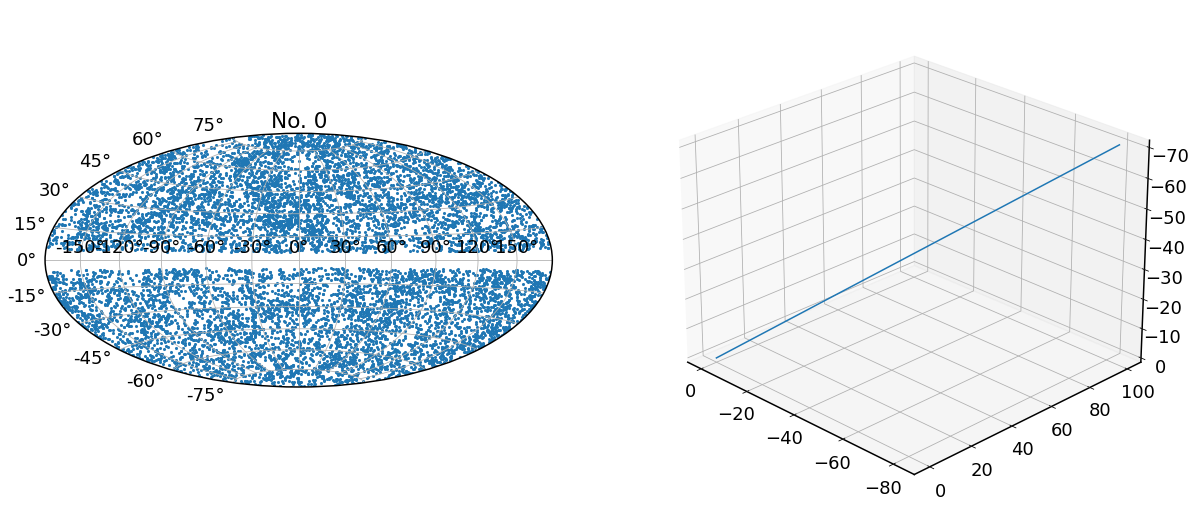

In [16]:
data = np.load(path)
bf = data['header']
data = data['data']

# glat and glon are in degrees, make unit objects to ease operations
glon, glat = data[: ,2], data[: ,3]
glon = c.Angle(glon, u.degree)
glat = c.Angle(glat, u.degree)
            
# changing range of glon to (-180, 180) instead of (0, 360)
glon = glon.wrap_at('180d', inplace=False)

# making figure
fig = plt.figure(figsize=(20, 20))
P.update({'font.size': 18,
                'axes.linewidth': 1.5,
                'axes.labelweight': 'bold',
                })

# subplot 1 (glon, glat) (hammer projection)
ax1 = fig.add_subplot(121, projection='hammer')
ax1.scatter(glon.radian, glat.radian, marker='.', linewidths=0.1)
ax1.grid(True)
ax1.title.set_text(f'No. 0')

# bulkflow visualization
x,y,z = bf[0], bf[1], bf[2]

ax = fig.add_subplot(122, projection='3d')
ax.plot((0, x) ,(0, y),(0, z))
ax.view_init(-155, 45)

fig.show()

#### misc

In [ ]:
# data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-version-2.npy')
# for line in data:
#     print(line)

In [ ]:
# import numpy as np

In [ ]:
# data = np.load('C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-0.npy')
# data.shape[0]

In [ ]:
# lens = []
# for i in range(300):
#     data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-{i}.npy')
#     lens.append(data.shape[0])
    

# print(min(lens))
# print(max(lens))
